In [3]:
#вопрос самый главный - как не просто копировать чужой код в плане func connec а попробовать сделать как-то по своему
#вопрос другой - можно ли сгенерировать похожие данные или каким-то образом найти похожий датасет
#и скормить алгоритмам два датасета

from nilearn import datasets
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm #бар прогрузки
import pickle #и что это такое
import os
warnings.filterwarnings('ignore')

основная задача - по функциональной связности предсказать какие-то фенотипические признаки
референс: https://github.com/brainhack-school2020/tjays7_fmri

мы будем работать с библиотекой нилерн - она помогает обрабатывать фмрт данные. чтобы не искать долго датасет и не обрабатывать его, возьмём обработанные (именно мрт часть) датасеты которые есть в самом нилерне. для этого проекта возьмём датасет с resting state ADHD 

In [4]:
adhd = datasets.fetch_adhd()
adhd.keys()

Resuming failed, try to download the whole file.


Downloaded 70959104 of 72402326 bytes (98.0%,    0.1s remaining) ...done. (7 seconds, 0 min)
Extracting data from /home/datalore/nilearn_data/adhd/1195d4b51afa739d0af4c7d508e1f39a/adhd40_0027011.tgz..... done.
Downloaded 75309056 of 76184603 bytes (98.9%,    0.1s remaining) ...done. (6 seconds, 0 min)
Extracting data from /home/datalore/nilearn_data/adhd/1195d4b51afa739d0af4c7d508e1f39a/adhd40_0027018.tgz..... done.
Downloaded 62554112 of 70074120 bytes (89.3%,    0.6s remaining) ...done. (6 seconds, 0 min)
Extracting data from /home/datalore/nilearn_data/adhd/1195d4b51afa739d0af4c7d508e1f39a/adhd40_0027034.tgz..... done.
Downloaded 65708032 of 69291635 bytes (94.8%,    0.3s remaining) ...done. (6 seconds, 0 min)
Extracting data from /home/datalore/nilearn_data/adhd/1195d4b51afa739d0af4c7d508e1f39a/adhd40_0027037.tgz..... done.
Downloaded 33619968 of 41803342 bytes (80.4%,    0.7s remaining) ...done. (4 seconds, 0 min)
Extracting data from /home/datalore/nilearn_data/adhd/1195d4b51afa7

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

func и confounds нам понадобятся для того чтобы показать саму связность 
а phenotypic - как раз то, что мы будем предсказывать, эти данные ещё предстоит обработать  

**обработка и препроцессинг данных** 

In [5]:
#посмотрим на наш датасет

pheno = adhd.phenotypic
ph = pd.DataFrame(pheno)
len(ph)

30

In [6]:
ph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   f0                          30 non-null     object 
 1   Subject                     30 non-null     int64  
 2   RestScan                    30 non-null     object 
 3   MeanFD                      30 non-null     float64
 4   NumFD_greater_than_020      30 non-null     int64  
 5   rootMeanSquareFD            30 non-null     float64
 6   FDquartiletop14thFD         30 non-null     float64
 7   PercentFD_greater_than_020  30 non-null     float64
 8   MeanDVARS                   30 non-null     float64
 9   MeanFD_Jenkinson            30 non-null     float64
 10  site                        30 non-null     object 
 11  sibling_id                  30 non-null     object 
 12  data_set                    30 non-null     object 
 13  age                         30 non-nu

In [7]:
for i in ph: 
    print(i, ph[i].unique())

f0 [b'"21"' b'"19"' b'"22"' b'"20"' b'"30"' b'"27"' b'"15"' b'"11"' b'"9"'
 b'"13"' b'"5"' b'"29"' b'"32"' b'"36"' b'"25"' b'"38"' b'"28"' b'"1"'
 b'"23"' b'"33"' b'"16"' b'"7"' b'"39"' b'"35"' b'"40"' b'"6"' b'"8"'
 b'"2"' b'"34"' b'"31"']
Subject [  10042   10064   10128   21019   23008   23012   27011   27018   27034
   27037 1019436 1206380 1418396 1517058 1552181 1562298 1679142 2014113
 2497695 2950754 3007585 3154996 3205761 3520880 3624598 3699991 3884955
 3902469 3994098 4016887]
RestScan [b'"rest_1"']
MeanFD [0.0559 0.0623 0.0689 0.0575 0.0801 0.0569 0.1212 0.0622 0.0484 0.0686
 0.0904 0.0719 0.0713 0.0733 0.0408 0.0722 0.1482 0.0576 0.0482 0.0523
 0.0528 0.0881 0.0679 0.0509 0.0653 0.1113 0.0988 0.058  0.0547 0.0879]
NumFD_greater_than_020 [ 0  7  1  5  2  8 14 15  3]
rootMeanSquareFD [0.2365 0.2496 0.2624 0.2398 0.2831 0.2386 0.3482 0.2494 0.2201 0.2619
 0.3006 0.2681 0.267  0.2708 0.2021 0.2686 0.3849 0.24   0.2195 0.2287
 0.2298 0.2968 0.2605 0.2255 0.2556 0.3337 0.3144 0

In [8]:
for i in ph: 
    print(i, pd.DataFrame(ph[i]).value_counts())

f0 f0     
b'"9"'     1
b'"8"'     1
b'"11"'    1
b'"13"'    1
b'"15"'    1
b'"16"'    1
b'"19"'    1
b'"2"'     1
b'"20"'    1
b'"21"'    1
b'"22"'    1
b'"23"'    1
b'"25"'    1
b'"27"'    1
b'"28"'    1
b'"29"'    1
b'"30"'    1
b'"31"'    1
b'"32"'    1
b'"33"'    1
b'"34"'    1
b'"35"'    1
b'"36"'    1
b'"38"'    1
b'"39"'    1
b'"40"'    1
b'"5"'     1
b'"6"'     1
b'"7"'     1
b'"1"'     1
dtype: int64
Subject Subject
4016887    1
3994098    1
10064      1
10128      1
21019      1
23008      1
23012      1
27011      1
27018      1
27034      1
27037      1
1019436    1
1206380    1
1418396    1
1517058    1
1552181    1
1562298    1
1679142    1
2014113    1
2497695    1
2950754    1
3007585    1
3154996    1
3205761    1
3520880    1
3624598    1
3699991    1
3884955    1
3902469    1
10042      1
dtype: int64
RestScan RestScan   
b'"rest_1"'    30
dtype: int64
MeanFD MeanFD
0.1482    1
0.1212    1
0.0482    1
0.0484    1
0.0509    1
0.0523    1
0.0528    1
0.0547    1
0.055

In [9]:
#так как мы будет предсказывать данные не основываясь на этой табличке, а на основе данных функциональной связности
#я выберу несколько таргетов, самое важное - предсказать СДВГ, но мы попробуем ещё возраст и пол

target_dataset = ph[['sex', 'adhd', 'age']]
target_dataset

,sex,adhd,age
0,"b'""M""'",1,10.650000
1,"b'""M""'",1,15.900000
2,"b'""M""'",0,9.530000
3,"b'""M""'",0,15.530000
4,"b'""M""'",0,9.170000
5,"b'""F""'",1,11.330000
6,"b'""M""'",1,20.820000
7,"b'""M""'",1,19.080000
8,"b'""M""'",1,13.350000
9,"b'""M""'",1,17.740000


In [10]:
#сдвг у нас и так хорошо закодировано, нам остаётся только заенкодить пол

le = LabelEncoder()
target_dataset['sex'] = le.fit_transform(target_dataset['sex'])
target_dataset

,sex,adhd,age
0,1,1,10.650000
1,1,1,15.900000
2,1,0,9.530000
3,1,0,15.530000
4,1,0,9.170000
5,0,1,11.330000
6,1,1,20.820000
7,1,1,19.080000
8,1,1,13.350000
9,1,1,17.740000


делим мозг на части, чтобы определить наши регионы интереса ROI 


Dataset created in /home/datalore/nilearn_data/basc_multiscale_2015



 ...done. (0 seconds, 0 min)
Extracting data from /home/datalore/nilearn_data/basc_multiscale_2015/53337d5c408465aa257d35f81c13413b/1861819..... done.


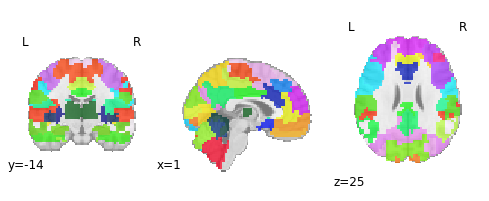

In [11]:
#вопрос - как выбрать атлас?
#пояснить для себя самой же что каждая штучка значит
mlscale = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_fname = mlscale.scale064

plotting.plot_roi(atlas_fname, draw_cross=False)

дальше начинаем работать с временными рядами
пока что на одном пациенте 

In [12]:
#тоже пояснить для себя все гиперпараметры и вообще всё что происходит 
#почитать про временные ряды
mask = NiftiLabelsMasker(labels_img=atlas_fname, standardize=True, memory='nilearn_cache', verbose=0)

sub = adhd.func[0]
conf = adhd.confounds[0]
time_series = mask.fit_transform(sub, confounds=conf)

In [13]:
sub_all = adhd.func
len(sub_all)

30

In [14]:
time_series.shape

(176, 64)

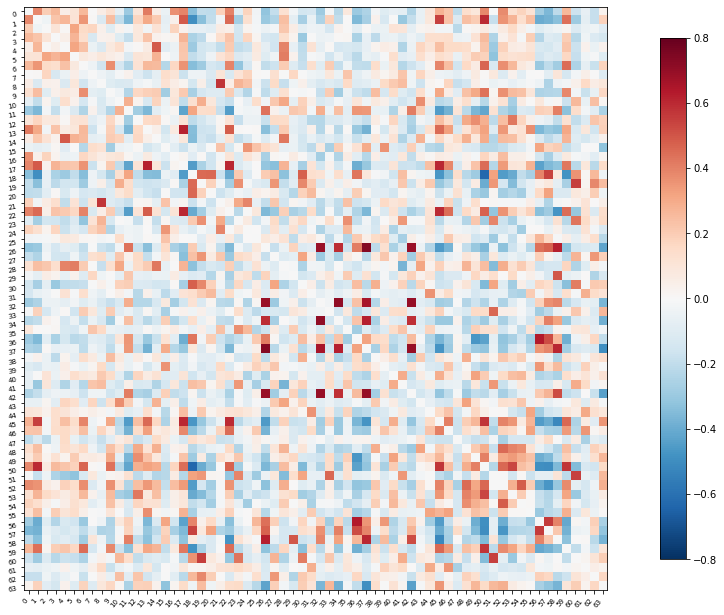

In [15]:
#дальше делаем матрицы корреляций для функциональной связности между регионами 
#нам понадобятся векторизированный и невекторизированный набор - один для красивой картинки, другой мы будем потом
#кормить моделям, тоже почитать почему мы берем те или иные гиперпараметры 

vector_corr = ConnectivityMeasure(kind='correlation', discard_diagonal=True, vectorize=True)
nonvector_corr = ConnectivityMeasure(kind='correlation', discard_diagonal=True)

#почему нули? 
vector_corr = vector_corr.fit_transform([time_series])[0]
nonvector_corr = nonvector_corr.fit_transform([time_series])[0]

#надо подтюнить картинку на сиборне 
np.fill_diagonal(nonvector_corr, 0)
plotting.plot_matrix(nonvector_corr, figure=(12, 12), 
                     labels=range(time_series.shape[-1]), 
                     vmax=0.8, vmin=-0.8, reorder=False)


In [16]:
#понять что я здесь делаю
all_features_vec = []
all_features_nonvec = []

vector_corr = ConnectivityMeasure(kind='correlation', discard_diagonal=True, vectorize=True)
nonvector_corr = ConnectivityMeasure(kind='correlation', discard_diagonal=True)

def all_vecs(corr_measure, vec_list): 
    for i,sub in enumerate(tqdm(adhd.func)):
        time_series = mask.fit_transform(sub, confounds=adhd.confounds[i])
        corr_matrix = corr_measure.fit_transform([time_series])[0]
        vec_list.append(corr_matrix)

all_vecs(vector_corr, all_features_vec)
all_vecs(nonvector_corr, all_features_nonvec)

100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


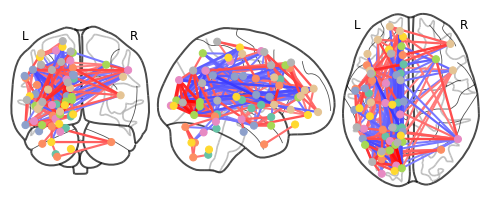

In [17]:
mean_corr_matrix = nonvector_corr.mean_
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_fname)

view = plotting.view_connectome(mean_corr_matrix, coordinates, edge_threshold='80%', edge_cmap='Dark2')
view.save_as_html('surface-plot.html')

plotting.plot_connectome(mean_corr_matrix, coordinates, edge_threshold='90%')

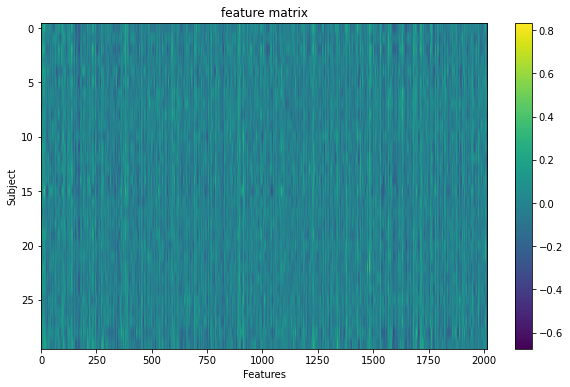

In [18]:
fig, ax = plt.subplots(1, figsize = (10,6))
img = ax.imshow(all_features_vec, aspect = 'auto')
fig.colorbar(img, ax = ax)
ax.set(title = 'feature matrix', xlabel = 'Features', ylabel = 'Subject')

In [19]:
features = pd.DataFrame(all_features_vec)

In [20]:
#у нас аж 2016 предикторов, это вообще-то мягко говоря очень много 
#и чтобы снизить размерность наших данных мы воспользуемся методом главных компонент 

In [21]:
pca = PCA(.95)
features_pca = pca.fit_transform(features)
df_features = pd.DataFrame(features_pca)

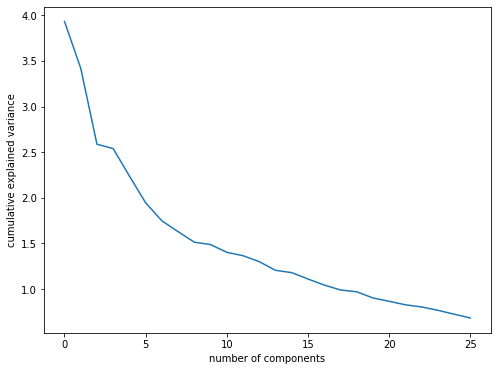

In [22]:
fig, ax = plt.subplots(1, figsize = (8,6))
ax.plot(pca.explained_variance_)
ax.set(xlabel = 'number of components')
ax.set(ylabel = 'cumulative explained variance')
fig.show()

In [23]:
df_adhd = pd.concat([df_features, target_dataset['adhd']], axis=1, sort=False)
df_age = pd.concat([df_features, target_dataset['age']], axis=1, sort=False)

In [24]:
#здесь будут графики и возможно нормализация

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_adhd.drop(['adhd'], axis=1), df_adhd['adhd'], test_size=0.2, random_state=17)

In [26]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [27]:
#классификаторы - хгбуст, к ближайших соседей, логистическая регрессия, случайный лес 
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression())])

param_grid = [
    {'classifier': [LogisticRegression()], 'preprocessing': [StandardScaler()], 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}, 
    {'classifier': [RandomForestClassifier()], 'preprocessing': [StandardScaler()], 'classifier__n_estimators': [10, 50, 100]},
    {'classifier': [XGBClassifier(eval_metric='mlogloss')], 'preprocessing': [StandardScaler()], 'classifier__n_estimators': [10, 50, 100],
                'classifier__max_depth': [2,4,5,10]},
    {'classifier': [KNeighborsClassifier()], 'preprocessing': [StandardScaler()], 'classifier__n_neighbors': [2, 3, 4, 5]},
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'preprocessing': [StandardScaler()]},
                         {'classifier': [RandomForestClassifier(n_estimators=10)],
                          'classifier__n_estimators': [10, 50, 100],
                          'preprocess...
                                                       random_state=None,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
                                                       scale_pos_weight=None,
                                                       subsample=None,
                                                       tree_meth

In [28]:
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': RandomForestClassifier(n_estimators=10), 'classifier__n_estimators': 10, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.79
Test-set score: 0.17


In [29]:
grid.cv_results_

{'mean_fit_time': array([0.00984855, 0.00914259, 0.0091248 , 0.00957794, 0.01012588,
        0.01032128, 0.02323375, 0.08568473, 0.16309152, 0.04997892,
        0.16462936, 0.31190481, 0.04791694, 0.16625724, 0.30799398,
        0.04582596, 0.16429572, 0.30962968, 0.04826503, 0.16798992,
        0.31335015, 0.00561986, 0.00557981, 0.00552354, 0.00535655]),
 'std_fit_time': array([7.86683733e-04, 1.10150767e-04, 9.81716575e-05, 2.28046213e-04,
        2.91184662e-04, 2.34770841e-04, 1.70313624e-03, 1.36841581e-04,
        1.42458003e-03, 1.05700795e-02, 2.81665909e-03, 8.36766533e-03,
        1.56197572e-03, 5.28167189e-03, 5.49503947e-03, 9.77113629e-04,
        3.78183024e-03, 8.47400982e-03, 1.12200688e-03, 5.80565911e-03,
        5.79572795e-03, 1.01911670e-04, 2.92198870e-05, 1.64501536e-04,
        6.52969251e-05]),
 'mean_score_time': array([0.00259666, 0.00263219, 0.00260983, 0.00271688, 0.00265903,
        0.00273242, 0.00458603, 0.00991783, 0.01620798, 0.00657253,
        0.00

In [30]:
#ну, с регрессией на тестовой выборке все вообще как-то очень плохо 
#сделаем функцию для графиков 
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

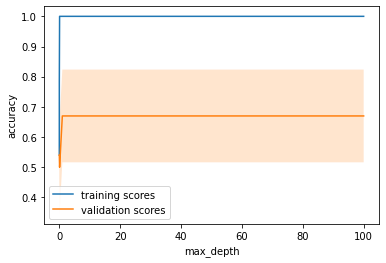

In [31]:
#для хорошей жизни нам явно чего-то не хватает, чтобы посмотреть чего именно - можно использовать кривые обучения и валидации 
max_depth = [0.001, 0.01, 0.1, 1, 10, 100]
val_train, val_test = validation_curve(pipe, X_train, y_train, param_name='classifier__C', param_range = max_depth, cv=5)

plot_with_err(max_depth, val_train, label='training scores')
plot_with_err(max_depth, val_test, label='validation scores')
plt.xlabel('max_depth'); plt.ylabel('accuracy')
plt.legend();

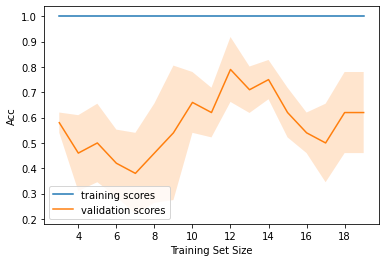

In [32]:
def plot_learning_curve(C=10):
    train_sizes = np.linspace(0.01, 1, 30)
    grid.set_params(estimator__classifier__C=C)
    N_train, val_train, val_test = learning_curve(pipe,
                                                  X_train, y_train, train_sizes=train_sizes, cv=5,
                                                  scoring='accuracy')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('Acc')
    plt.legend()

plot_learning_curve()

In [33]:
columns = df_adhd.columns

In [34]:
#кривые обучения не сошлись и на самом деле довольно далеко друг от друга. ну и это логично - данных мало
#обрабатывать данные фмрт самостоятельно довольно долго и я это не умею, так что будет генерировать синтетик дата
from ctgan import CTGANSynthesizer

ctgan = CTGANSynthesizer(epochs=10)
ctgan.fit(df_adhd, columns)

synthetic_data = ctgan.sample(30)
synthetic_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,adhd
0,0.649274,0.618562,-0.386694,-1.080882,-0.590720,-0.681319,2.082686,0.294579,1.852440,-1.893288,...,-1.337730,1.141864,0.368446,-0.181648,-0.713811,0.321375,0.557223,0.662870,1.058421,0
1,-1.780713,0.883568,1.766756,3.216469,-0.827755,-1.618903,2.082686,-2.124739,1.296750,-1.893288,...,-1.631559,0.347737,0.459267,2.036742,0.243675,0.405404,1.968022,1.610422,0.287022,1
2,-0.587500,-1.661088,-1.193796,-1.083969,0.338227,1.734724,-0.715714,-0.823792,0.045335,1.096461,...,-1.199718,0.221193,-1.244610,-0.011611,0.441458,0.294586,-0.128712,-0.247305,1.824208,0
3,-2.429528,-0.630067,1.157115,-2.214903,0.730304,-0.427201,-1.422197,0.839793,-0.276117,0.755098,...,0.400505,2.351990,1.559699,0.424186,0.441458,-0.126794,0.557223,1.610422,0.026256,1
4,-2.470186,1.039402,1.157115,-0.693149,-2.533147,-0.196881,-0.914042,-2.124739,-1.644149,1.096461,...,0.119970,-1.310207,-0.114865,2.036742,0.391437,2.254115,-0.248382,0.112149,0.381385,0


In [35]:
#теперь когда мы убедились что с синтетическими данными в целом все хорошо, попробуем запихнуть
#их в модельку и понадеяться на лучшее 
df_adhd_synth = pd.concat([df_adhd, synthetic_data], axis=0)
df_adhd_synth.head(5)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,adhd
0,1.904906,-0.024966,4.092744,0.361890,-1.503911,-1.439143,0.809402,1.113619,-0.952892,-0.615148,...,0.464690,-0.506063,-0.456334,0.723828,0.232082,1.356453,0.385773,1.610422,-1.236748,1
1,-0.422353,-0.969937,-0.386694,-0.693149,0.272680,-1.103422,-0.639019,1.153164,-0.367149,2.672094,...,-0.505417,1.299206,1.524842,0.194186,-0.713811,2.254115,0.557223,-1.724015,0.287022,1
2,4.273800,1.039402,1.484356,-1.685655,-2.533147,0.723272,0.295050,-0.823792,-0.276117,-1.006712,...,-0.692387,0.458824,0.574788,-0.011611,0.554441,-0.359608,-0.693953,-0.706792,0.182340,0
3,0.890570,-0.865488,1.245415,-2.306438,-0.193912,0.158603,-0.315164,-0.628671,1.821789,1.096461,...,0.303769,-0.376316,-0.599384,-0.877762,-0.822198,-1.380867,0.331443,0.112149,1.824208,0
4,-1.276053,0.239007,-0.162086,1.570077,4.031562,0.422688,2.480069,-2.567009,-0.596406,0.161908,...,0.037877,-0.319629,0.017849,0.347164,-0.378782,0.251028,0.083118,0.299389,-0.132000,0


In [44]:
df_adhd_synth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 29
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       60 non-null     float64
 1   1       60 non-null     float64
 2   2       60 non-null     float64
 3   3       60 non-null     float64
 4   4       60 non-null     float64
 5   5       60 non-null     float64
 6   6       60 non-null     float64
 7   7       60 non-null     float64
 8   8       60 non-null     float64
 9   9       60 non-null     float64
 10  10      60 non-null     float64
 11  11      60 non-null     float64
 12  12      60 non-null     float64
 13  13      60 non-null     float64
 14  14      60 non-null     float64
 15  15      60 non-null     float64
 16  16      60 non-null     float64
 17  17      60 non-null     float64
 18  18      60 non-null     float64
 19  19      60 non-null     float64
 20  20      60 non-null     float64
 21  21      60 non-null     float64
 22  22  

In [36]:
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(df_adhd_synth.drop(['adhd'], axis=1), df_adhd_synth['adhd'], test_size=0.4, random_state=17)

In [37]:
grid_synth = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid_synth.fit(X_train_synth, y_train_synth)

print("Best params:\n{}\n".format(grid_synth.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_synth.best_score_))
print("Test-set score: {:.2f}".format(grid_synth.score(X_test_synth, y_test_synth)))

Best params:
{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='mlogloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), 'classifier__max_depth': 2, 'classifier__n_estimators': 100, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.56
Test-set score: 0.50


In [38]:
from sklearn.inspection import permutation_importance

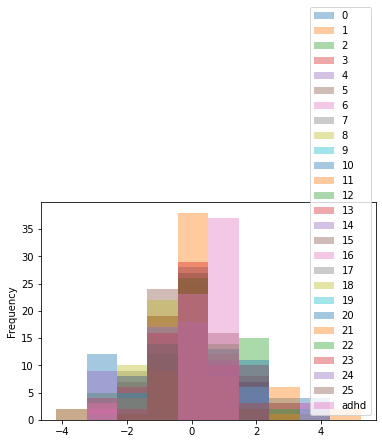

In [39]:
df_adhd_synth.plot(kind='hist', alpha=0.4)

In [40]:
df_adhd_synth.describe()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,adhd
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.016811,0.019893,-0.036882,-0.114764,-0.289545,-0.078582,-0.031315,-0.133524,-0.095262,-0.031647,...,-0.008971,-0.020515,0.005847,0.166775,0.034277,0.088526,-0.015063,-0.070214,0.154595,0.616667
std,2.061778,1.792618,1.595888,1.460365,1.688974,1.359250,1.305264,1.155268,1.260939,1.209979,...,1.038159,1.035657,1.008071,1.063294,0.745928,0.880320,0.773529,0.971008,0.784899,0.490301
min,-3.456679,-4.186746,-3.159638,-2.618741,-2.764058,-3.003476,-2.907267,-2.567009,-2.020235,-1.910165,...,-1.718721,-1.421869,-2.007487,-1.860255,-2.102498,-1.522336,-1.502723,-1.724015,-1.464660,0.000000
25%,-1.780713,-1.235413,-1.193796,-1.083969,-1.433377,-0.937539,-0.914042,-0.823792,-1.227886,-0.751021,...,-0.534752,-0.717058,-0.506664,-0.445838,-0.379213,-0.540942,-0.502186,-0.710693,-0.270669,0.000000
50%,0.353325,0.071559,0.398743,-0.281533,-0.465894,-0.427201,-0.185236,-0.087139,-0.276117,-0.065308,...,0.037877,-0.219445,-0.054614,-0.011611,0.219030,0.240312,-0.056196,0.030515,0.095622,1.000000
75%,1.433893,1.039402,1.484356,1.044061,0.400158,0.674755,0.708520,0.481578,0.881791,0.755098,...,0.589345,0.331199,0.488147,0.499096,0.403942,0.577540,0.385773,0.605524,0.572711,1.000000
max,4.273800,5.215908,4.092744,3.216469,4.031562,3.043763,3.094482,2.772162,2.942429,3.548714,...,2.402969,2.351990,2.025634,2.265234,2.745743,2.254115,2.351889,1.779469,1.824208,1.000000


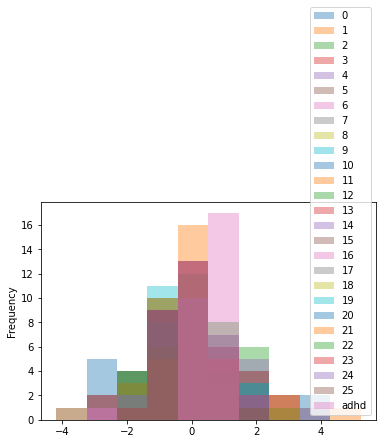

In [41]:
df_adhd.plot(kind='hist', alpha=0.4)

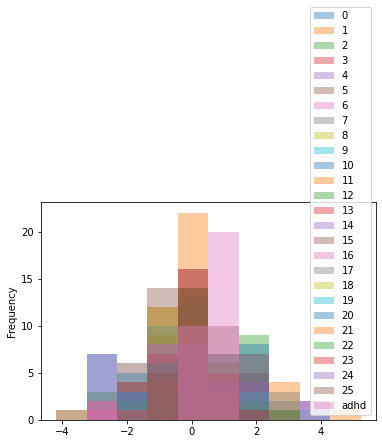

In [42]:
synthetic_data.plot(kind='hist', alpha=0.4)

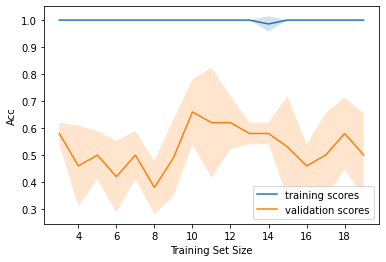

In [43]:
def plot_learning_curve(C=10):
    train_sizes = np.linspace(0.1, 1, 20)
    pipe.set_params(classifier__C=C)
    N_train, val_train, val_test = learning_curve(pipe,
                                                  X_train, y_train, train_sizes=train_sizes, cv=5,
                                                  scoring='accuracy')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('Acc')
    plt.legend()

plot_learning_curve(C=0.1)